## Tech Challenge - Fase 2


####Dicionário das features da base de dados
*   **data:** data da amostragem
*   **ultimo:** valor final em que fechou a bolsa
*   **abertura:** valor inicial quando abriu a bolsa
*   **maxima:** valor máximo alcançado naquele dia
*   **minima:** valor mínimo alcançado naquele dia
*   **volume:** a quantidade total de de ativos financeiros que foram negociados durante um determinado período, neste caso, durante um dia
*   **variacao:** percentual de variacao do ultimo do dia anterior comparado ao ultimo do dia atual. (%) Calcula-se com o mais recente/menos recente. Exemplo, dividindo 133,533/132,753 temos 1,0059... multiplica-se por 100 para capturar a porcentagem somente após o número 1.Ou seja, aumentou 0,59%(número positivo por causa do 1 na frente, se fosse com o 0 na frente, entao teríamos que colocar um sinal de negativo e também subtrair o valor encontrado de 1)

### Obtendo os dados

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [5]:
df =  pd.read_csv("/content/drive/MyDrive/Tech Challenges/Fase 2/Base dados/8 anos com pandemia/Dados Históricos - Ibovespa.csv", sep=',');
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,28.12.2023,134.185,134.194,134.389,133.832,"7,81M","-0,01%"
1,27.12.2023,134.194,133.523,134.195,133.328,"6,17M","0,49%"
2,26.12.2023,133.533,132.753,133.645,132.753,"5,15M","0,59%"
3,22.12.2023,132.753,132.182,133.035,132.094,"8,23M","0,43%"
4,21.12.2023,132.182,130.826,132.277,130.822,"8,68M","1,05%"


###Análise Exploratória e Tratamento de Dados

In [6]:
df.rename(columns={"Data":"data", "Último":"ultimo", "Abertura":"abertura", "Máxima":"maxima", "Mínima":"minima", "Vol.": "volume", "Var%":"variacao" }, inplace=True)

In [7]:
df.shape

(2228, 7)

In [8]:
df.isnull().sum()

data        0
ultimo      0
abertura    0
maxima      0
minima      0
volume      1
variacao    0
dtype: int64

In [9]:
df.dropna(inplace=True)

O dado nulo encontrado diz respeito ao dia 10/02/2016.
Possíveis motivos:

1. Problemas Técnicos: Pode haver problemas técnicos ou falhas na coleta e atualização de dados. Às vezes, esses problemas podem resultar na ausência de dados para determinadas datas.

2. Feriado ou Suspensão do Mercado: Se 10/02/2016 foi um feriado ou se houve uma suspensão do mercado naquela data, isso poderia explicar a ausência de dados de volume.

3. Erro na Fonte de Dados: Pode haver um erro na fonte de dados em questão. As plataformas online que fornecem dados financeiros podem ocasionalmente apresentar erros ou falhas.

O dia 10/02/2016 foi uma quarta-feira de cinzas, podendo ser esta a causa da ausência de dados de volume neste dia.
Obs.: porque nos os outros anos não tem esse valor nulo no ponto facultativo da quarta-feira de cinzas?

https://br.advfn.com/indice/ibovespa/2016/02:

10 de Fevereiro de 2016 – Fed e Carnaval fazem Ibovespa amargar segunda queda consecutiva neste mini pregão de Quarta-Feira de Cinzas

O clima no principal mercado acionário do Brasil foi de pessimismo na volta do feriado de Carnaval. Após dois dias sem abrir, as ações brasileiras tiveram que se ajustar às quedas registradas por suas ADRs negociadas na Bolsa de Valores de Nova Iorque. American Depositary Receipts (ADRs) são recibos de ações de empresas estrangeiras negociadas no mercado acionário dos Estados Unidos. Os investidores também se decepcionaram com os comentários da presidente do Federal Reserve (Fed), banco central norte-americano, de que a instituição pretende realizar alguns ajustes em sua política monetária nas próximas reuniões com seus presidentes regionais. Tudo isso pesou, fazendo com que o principal índice de ações do país encerrasse o Carnaval em baixa, a segunda desvalorização consecutiva.

In [10]:
df.isnull().sum()

data        0
ultimo      0
abertura    0
maxima      0
minima      0
volume      0
variacao    0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2227 entries, 0 to 2227
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   data      2227 non-null   object 
 1   ultimo    2227 non-null   float64
 2   abertura  2227 non-null   float64
 3   maxima    2227 non-null   float64
 4   minima    2227 non-null   float64
 5   volume    2227 non-null   object 
 6   variacao  2227 non-null   object 
dtypes: float64(4), object(3)
memory usage: 139.2+ KB


####Transformando a coluna 'data' para DateTime para facilitar as análises


In [12]:
df['data'] = pd.to_datetime(df['data'])
df.head()

<ipython-input-12-af75ee59d1bc>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['data'] = pd.to_datetime(df['data'])


,data,ultimo,abertura,maxima,minima,volume,variacao
0,2023-12-28,134.185,134.194,134.389,133.832,"7,81M","-0,01%"
1,2023-12-27,134.194,133.523,134.195,133.328,"6,17M","0,49%"
2,2023-12-26,133.533,132.753,133.645,132.753,"5,15M","0,59%"
3,2023-12-22,132.753,132.182,133.035,132.094,"8,23M","0,43%"
4,2023-12-21,132.182,130.826,132.277,130.822,"8,68M","1,05%"


In [13]:
df.describe().round(2)

,ultimo,abertura,maxima,minima
count,2227.00,2227.00,2227.00,2227.00
mean,88.17,88.13,88.97,87.31
std,25.49,25.49,25.64,25.32
min,37.50,37.50,38.03,37.05
25%,64.28,64.23,64.84,63.73
50%,95.44,95.42,96.40,94.39
75%,110.34,110.33,111.50,109.35
max,134.19,134.19,134.39,133.83


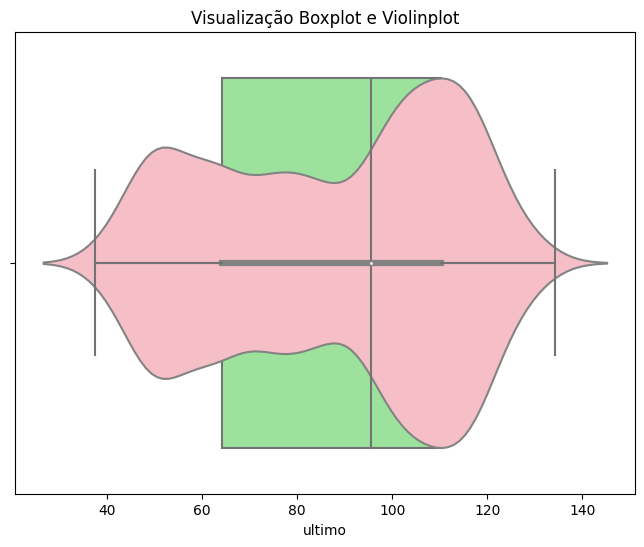

In [14]:
fig, ax = plt.subplots(figsize=(8,6))

sns.violinplot(x='ultimo', data=df, ax=ax, color='lightpink')

sns.boxplot(x='ultimo', data=df, ax=ax, whis=1.5, color='lightgreen')
ax.set_title('Visualização Boxplot e Violinplot')

plt.show()

No gráfico acima não vemos muitos outliers, mas será se é um bom gráfico para analisar esses dados?

Text(0, 0.5, 'Valor do fechamento')

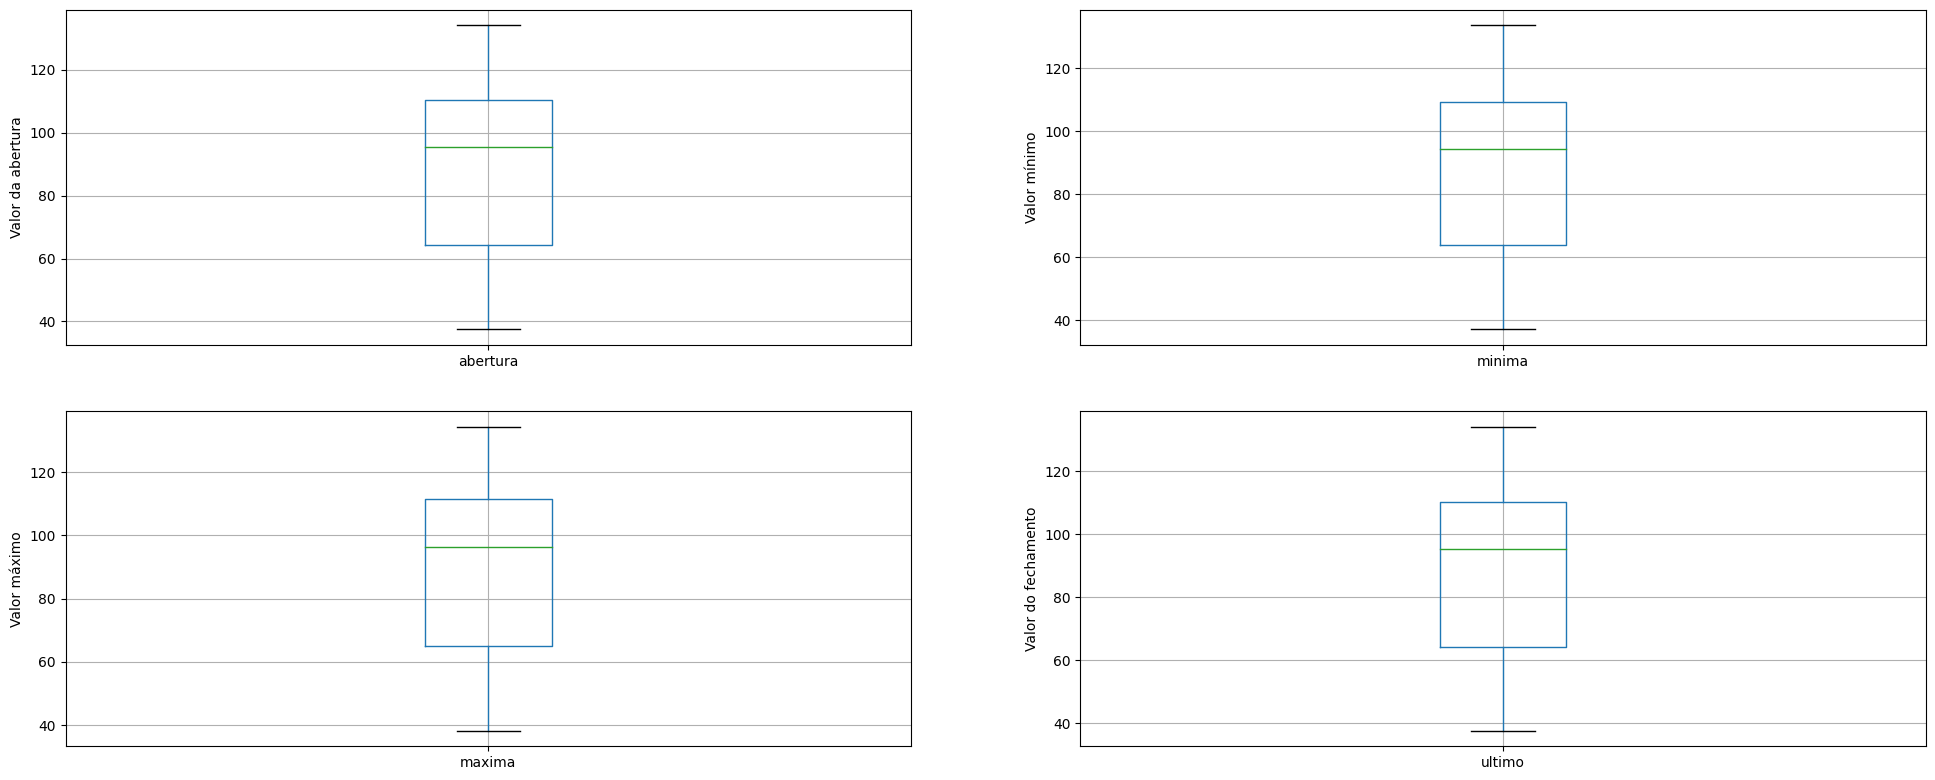

In [15]:
plt.figure(figsize=(24, 20))

plt.subplot(4, 2, 1)
fig = df.boxplot(column = "abertura")
fig.set_title("")
fig.set_ylabel("Valor da abertura")

plt.subplot(4, 2, 2)
fig = df.boxplot(column = "minima")
fig.set_title("")
fig.set_ylabel("Valor mínimo")

plt.subplot(4, 2, 3)
fig = df.boxplot(column = "maxima")
fig.set_title("")
fig.set_ylabel("Valor máximo")

plt.subplot(4, 2, 4)
fig = df.boxplot(column = "ultimo")
fig.set_title("")
fig.set_ylabel("Valor do fechamento")

<ipython-input-16-5521499a2e78>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


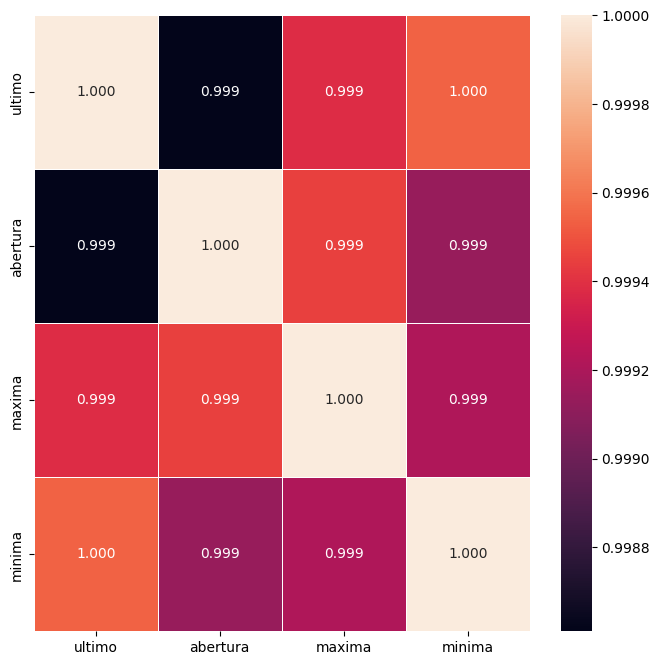

In [16]:
correlation_matrix = df.corr()

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(data = correlation_matrix, annot=True, linewidth=.5, ax=ax, fmt='.3f')

plt.show()

## Ajustando a escala

In [17]:
df.head()

,data,ultimo,abertura,maxima,minima,volume,variacao
0,2023-12-28,134.185,134.194,134.389,133.832,"7,81M","-0,01%"
1,2023-12-27,134.194,133.523,134.195,133.328,"6,17M","0,49%"
2,2023-12-26,133.533,132.753,133.645,132.753,"5,15M","0,59%"
3,2023-12-22,132.753,132.182,133.035,132.094,"8,23M","0,43%"
4,2023-12-21,132.182,130.826,132.277,130.822,"8,68M","1,05%"


In [18]:
df['volume'] = df['volume'].str[:-1]

In [19]:
df['variacao'] = df['variacao'].str[:-1]

In [20]:
df['volume'] = df['volume'].str.replace(',', '.')
df['variacao'] = df['variacao'].str.replace(',', '.')

In [22]:
df.head()

,data,ultimo,abertura,maxima,minima,volume,variacao
0,2023-12-28,134.185,134.194,134.389,133.832,7.81,-0.01
1,2023-12-27,134.194,133.523,134.195,133.328,6.17,0.49
2,2023-12-26,133.533,132.753,133.645,132.753,5.15,0.59
3,2023-12-22,132.753,132.182,133.035,132.094,8.23,0.43
4,2023-12-21,132.182,130.826,132.277,130.822,8.68,1.05


In [23]:
df['volume'] = pd.to_numeric(df['volume'])
df['variacao'] = pd.to_numeric(df['variacao'])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2227 entries, 0 to 2227
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   data      2227 non-null   datetime64[ns]
 1   ultimo    2227 non-null   float64       
 2   abertura  2227 non-null   float64       
 3   maxima    2227 non-null   float64       
 4   minima    2227 non-null   float64       
 5   volume    2227 non-null   float64       
 6   variacao  2227 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 139.2 KB


In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [26]:
df = df.set_index('data')
df.head()

,ultimo,abertura,maxima,minima,volume,variacao
data,,,,,,
2023-12-28,134.185,134.194,134.389,133.832,7.81,-0.01
2023-12-27,134.194,133.523,134.195,133.328,6.17,0.49
2023-12-26,133.533,132.753,133.645,132.753,5.15,0.59
2023-12-22,132.753,132.182,133.035,132.094,8.23,0.43
2023-12-21,132.182,130.826,132.277,130.822,8.68,1.05


In [27]:
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [28]:
df_scaled.head()

,ultimo,abertura,maxima,minima,volume,variacao
0,0.999907,1.000000,1.000000,1.000000,0.006743,0.514814
1,1.000000,0.993061,0.997987,0.994793,0.005067,0.532241
2,0.993164,0.985097,0.992279,0.988852,0.004025,0.535727
3,0.985098,0.979192,0.985948,0.982043,0.007172,0.530150
4,0.979193,0.965168,0.978082,0.968900,0.007631,0.551760


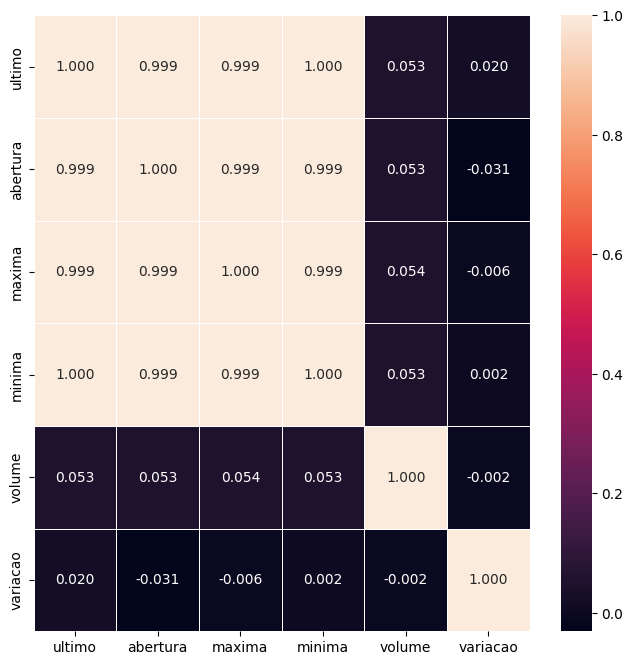

In [29]:
correlation_matrix_normalized = df_scaled.corr()

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(data = correlation_matrix_normalized, annot=True, linewidth=.5, ax=ax, fmt='.3f')

plt.show()

In [30]:
df.head()

,ultimo,abertura,maxima,minima,volume,variacao
data,,,,,,
2023-12-28,134.185,134.194,134.389,133.832,7.81,-0.01
2023-12-27,134.194,133.523,134.195,133.328,6.17,0.49
2023-12-26,133.533,132.753,133.645,132.753,5.15,0.59
2023-12-22,132.753,132.182,133.035,132.094,8.23,0.43
2023-12-21,132.182,130.826,132.277,130.822,8.68,1.05


## Análise Temporal

In [31]:
df_temporal = df[['ultimo']]
df_temporal.head()

,ultimo
data,
2023-12-28,134.185
2023-12-27,134.194
2023-12-26,133.533
2023-12-22,132.753
2023-12-21,132.182


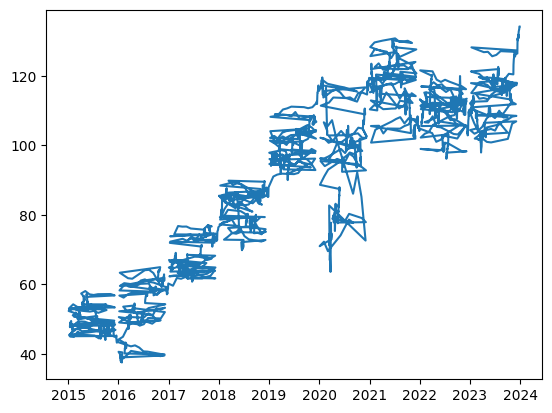

In [32]:
plt.plot(df_temporal.index, df_temporal.ultimo)

In [33]:
df_temporal.index = pd.to_datetime(df_temporal.index)

In [34]:
resultados = seasonal_decompose(df_temporal, period=5)

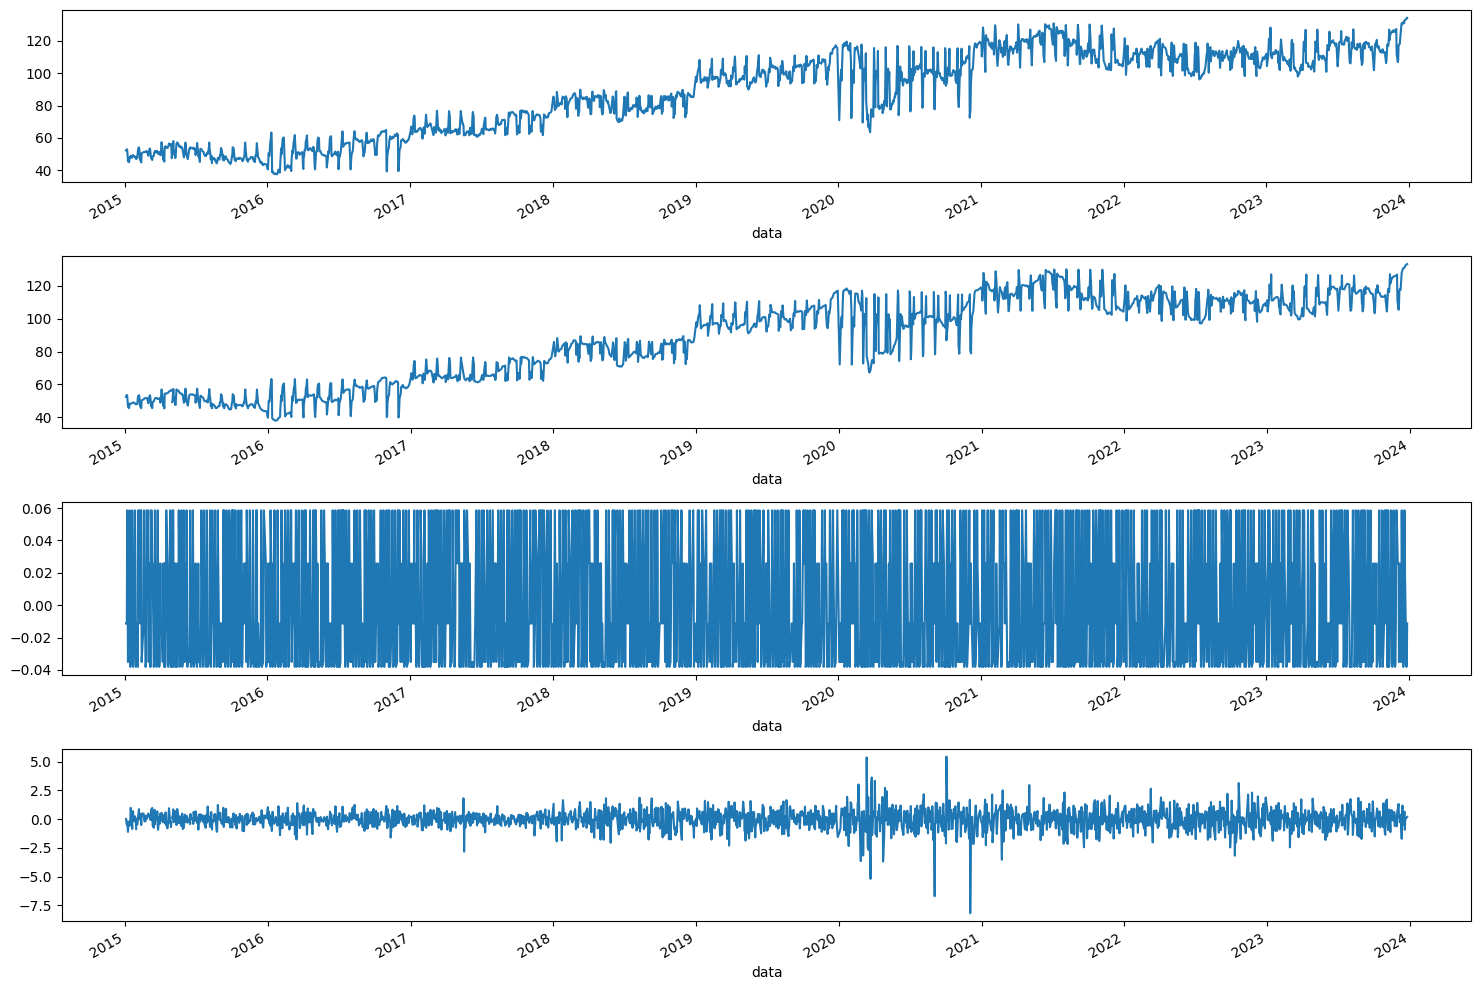

In [35]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize = (15,10))

resultados.observed.plot(ax=ax1)
resultados.trend.plot(ax=ax2)
resultados.seasonal.plot(ax=ax3)
resultados.resid.plot(ax=ax4)

plt.tight_layout()

In [38]:
sns.set_style('darkgrid')

In [39]:
X = df_temporal.ultimo.values

In [40]:
result = adfuller(X)

print("Teste ADF")
print(f"Teste Estatístico: {result[0]}")
print(f"P-Value: {result[1]}")
print("Valores críticos:")

for key, value in result[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -1.370675190740699
P-Value: 0.5962512899287659
Valores críticos:
	1%: -3.4333017061432964
	5%: -2.8628439752326242
	10%: -2.5674641688260897


O teste Augmented Dickey-Fuller (ADF) é comumente usado para verificar a estacionariedade de uma série temporal. Vamos analisar os resultados:


  **Teste Estatístico (-1.370675190740699)**: Este é o valor do teste estatístico ADF. Quanto mais negativo for esse valor, mais forte é a evidência contra a hipótese nula de que a série é não estacionária. Neste caso, o valor é negativo.

  **P-Value (0.5962512899287659)**: Este é o valor p associado ao teste estatístico. Um valor p maior que o nível de significância escolhido (por exemplo, 0.05) sugere que você não pode rejeitar a hipótese nula de que a série é não estacionária. Neste caso, o valor p é alto (0.596), sugerindo que você não pode rejeitar a hipótese nula.

  **Valores Críticos**: Esses são os valores críticos para diferentes níveis de significância (1%, 5%, 10%). Se o valor do teste estatístico for mais negativo do que esses valores críticos, você pode rejeitar a hipótese nula de que a série é não estacionária.

Em resumo, com base nos resultados fornecidos:

  1. O valor do teste estatístico é negativo, sugerindo evidência contra a hipótese nula de que a série é não estacionária.
  
  2. No entanto, o valor p é alto (0.596), indicando que você não pode rejeitar a hipótese nula a um nível de significância convencional.

Portanto, a conclusão seria que *não há evidência suficiente para rejeitar a hipótese nula de que a série temporal é não estacionária*, sugerindo que sua série pode não ser estacionária. Se você estiver buscando uma série estacionária para análises mais avançadas, pode ser necessário aplicar transformações à série ou considerar outros métodos para torná-la estacionária.

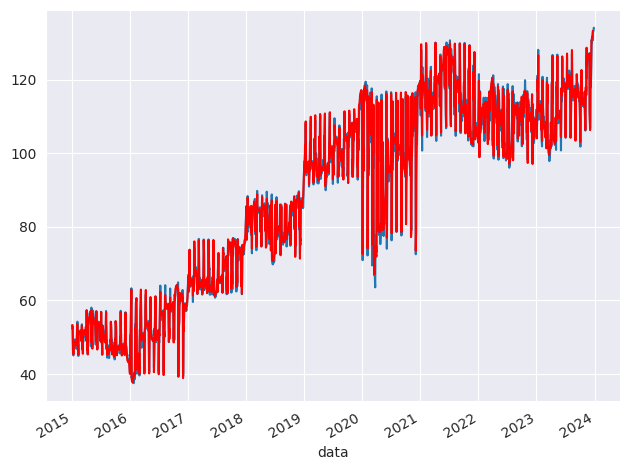

In [46]:
# média movel
ma = df_temporal.rolling(5).mean()

f, ax = plt.subplots()
df_temporal.plot(ax=ax, legend=False)
ma.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

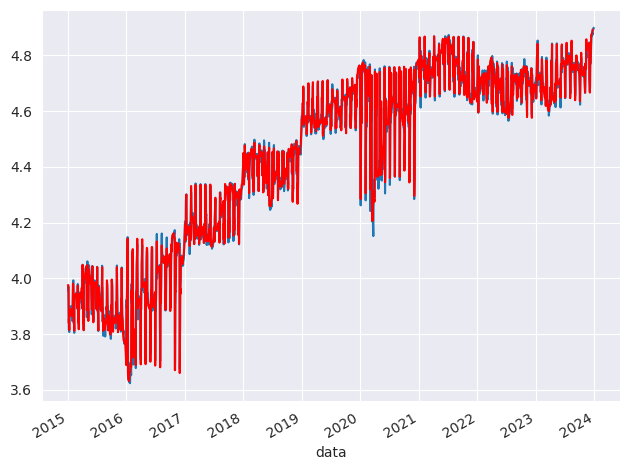

In [47]:
#transformando com log
df_log = np.log(df_temporal)
ma_log = df_log.rolling(5).mean()

f, ax = plt.subplots()
df_log.plot(ax=ax, legend=False)
ma_log.plot(ax=ax, legend=False, color='r')
plt.tight_layout()

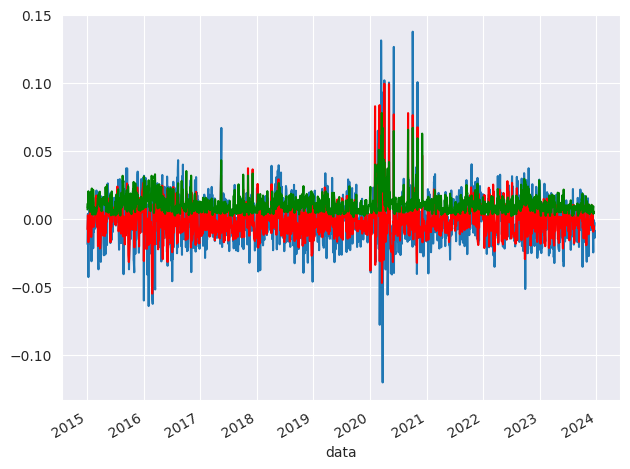

In [48]:
# subtraindo a média movel
df_s = (df_log - ma_log).dropna()

ma_s = df_s.rolling(5).mean()

std = df_s.rolling(5).std()

f, ax = plt.subplots()
df_s.plot(ax=ax, legend=False)
ma_s.plot(ax=ax, legend=False, color='r')
std.plot(ax=ax, legend=False, color='g')
plt.tight_layout()

In [49]:
X_s = df_s.ultimo.values
result_s = adfuller(X_s)

print("Teste ADF")
print(f"Teste Estatístico: {result_s[0]}")
print(f"P-Value: {result_s[1]}")
print("Valores críticos:")

for key, value in result_s[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -12.419027127247015
P-Value: 4.177266113148361e-23
Valores críticos:
	1%: -3.4333070451478593
	5%: -2.862846332675802
	10%: -2.5674654240037733
